# Gibbs Sampler

\begin{eqnarray}
r_{1:K}^{t} & \sim & p(r_{1:K}^{t} \mid x_{1:N}^{t}, \theta_{1:K}, w_{1:N}, \rho_{1:N}) 
\propto \Bigl(\prod_{k=1}^K \theta_{k \mid r^t_{\pi(\mathbf{r}_k)}}(r^t_k) \Bigr)
\Bigl( \prod_{n=1}^N \exp\bigl( \frac{1}{2} \log \rho_{n \mid r^t_{\pi(\mathbf{x}_n)}} - \frac{1}{2} ({w_{n \mid r^t_{\pi(\mathbf{x}_n)}}}^\mathrm{T} \phi(x^t_{\pi(\mathbf{x}_n)}) - x_n^t)^2 \bigr) \Bigr) \\
\theta_{k \mid r_{\pi(\mathbf{r}_k)}} & \sim & p(\theta_{k \mid r_{\pi(\mathbf{r}_k)}} \mid r_{1:K}^{1:T}) 
= \mathcal{D}(\theta_{k \mid r_{\pi(\mathbf{r}_k)}}; \gamma^*_{k \mid r_{\pi(\mathbf{r}_k)}}) \\
\rho_{n \mid r_{\pi(\mathbf{x}_n)}} & \sim & p(\rho_{n \mid r_{\pi(\mathbf{x}_n)}} \mid x_{1:N}^{1:T}, r_{1:K}^{1:T}) 
= \mathcal{G}(\rho_{n \mid r_{\pi(\mathbf{x}_n)}}; a^*_{n \mid r_{\pi(\mathbf{x}_n)}}, b^*_{n \mid r_{\pi(\mathbf{x}_n)}}) \\
w_{n \mid r_{\pi(\mathbf{x}_n)}} & \sim & p(w_{n \mid r_{\pi(\mathbf{x}_n)}} \mid \rho_{n \mid r_{\pi(\mathbf{x}_n)}}, x_{1:N}^{1:T}, r_{1:K}^{1:T}) 
= \mathcal{N}(w_{n \mid r_{\pi(\mathbf{x}_n)}}; m^*_{n \mid r_{\pi(\mathbf{x}_n)}}, (\rho_{n \mid r_{\pi(\mathbf{x}_n)}} \Lambda^*_{n \mid r_{\pi(\mathbf{x}_n)}})^{-1})
\end{eqnarray}

# Implementation

In [1]:
include("src/Misc.jl");
include("src/Datasets.jl");
include("src/BayesianCausality.jl");

In [2]:
using .Misc, .BayesianCausality
import .Datasets

In [3]:
using Statistics

import PyPlot, Seaborn 

In [4]:
import Base.Filesystem: mkpath

MARKER = ["o", "v", "d", "X", "p", "*", "P"];

RESULTS_PATH = "./results/abalone"
PARAMS_PATH = "./params"
IMG_PATH = "./img"
N_PARAMS = 36

36

In [5]:
import Random: randperm, seed!

seed!(8457);

## Read Data

In [6]:
abalone_data = Datasets.abalone()

X₁, X₂ = abalone_data[:whole], abalone_data[:height]

([0.514, 0.2255, 0.677, 0.516, 0.205, 0.3515, 0.7775, 0.768, 0.5095, 0.8945  …  0.577, 0.615, 0.791, 0.8395, 0.8675, 0.887, 0.966, 1.176, 1.0945, 1.9485], [0.095, 0.09, 0.135, 0.125, 0.08, 0.095, 0.15, 0.125, 0.125, 0.15  …  0.125, 0.125, 0.165, 0.13, 0.155, 0.165, 0.135, 0.205, 0.15, 0.195])

In [7]:
x = (X₁ .- mean(X₁)) ./ std(X₁)
y = (X₂ .- mean(X₂)) ./ std(X₂)

X = [x y];

## Read Parameters

In [8]:
N_PARAM = 20
params = Dict(Symbol(String(p)) => v for (p,v) ∈ load_json("$PARAMS_PATH/params-$N_PARAM.json"))

γ, M = params[:γ], params[:M]
a₁, b₁, m₁, λ₁ = params[:a₁], params[:b₁], params[:m₁], params[:λ₁]
a₂, b₂, m₂, λ₂ = params[:a₂], params[:b₂], params[:m₂], params[:λ₂]

(1.0, 1.0, 0.0, 0.1)

In [9]:
Rs = 1:5

causal_params = Dict(:γ=>γ, :m₁=>m₁, :m₂=>m₂, :λ₁=>λ₁, :λ₂=>λ₂, 
                     :a₁=>a₁, :a₂=>a₂, :b₁=>b₁, :b₂=>b₂);
spurious_params = Dict(:γ=>γ, :m₁=>m₁, :m₂=>m₂, :λ₁=>λ₁, :λ₂=>λ₁, 
                       :a₁=>a₁, :a₂=>a₁, :b₁=>b₁, :b₂=>b₁);

In [10]:
RPT, P = 100, 1000
EPOCHS = 100

100

## Model Selection

In [11]:
vb_scores = reshape([p for R ∈ Rs for p ∈ vb_causal_likelihoods(x, y, R; EPOCHS=EPOCHS, M=M, causal_params...)],3,:)    

3×5 Array{Float64,2}:
  -9691.02   -8449.26  -7694.06  -7455.85  -7364.56
  -9691.02   -8585.82  -7882.25  -7744.26  -7638.52
 -12143.2   -10616.2   -9648.61  -8876.14  -8545.83

In [12]:
save_json("$RESULTS_PATH/vb_scores.json", scores=vb_scores);

In [13]:
smc_scores = reshape([p for R ∈ Rs for p ∈ causal_likelihoods(x, y, R, P; M=M, causal_params...)],3,:)

3×5 Array{Float64,2}:
  -9691.02   -8791.07  -8486.31  -7909.67  -7778.76
  -9691.02   -8911.76  -8552.38  -8235.14  -8076.15
 -12143.2   -10642.2   -9721.46  -8935.8   -8785.88

In [14]:
save_json("$RESULTS_PATH/smc_scores.json", scores=smc_scores);

In [15]:
findmax(smc_scores) 

(-7778.763553257743, CartesianIndex(1, 5))

In [16]:
hyper_params = spurious_params;
M, R = 1, 5;

## Dual EM

In [17]:
r_em = dual_em(X, R; EPOCHS=EPOCHS, M=M, hyper_params...);

In [18]:
save_json("$RESULTS_PATH/dual_em.json", r=r_em);

## Particle Gibbs

In [19]:
log_Z, Πᵖ = smc_weight(X,R,P; M=M, hyper_params...)
for i ∈ 1:RPT
    Πᵖ = p_gibbs(X, Πᵖ,P; hyper_params...)
end

In [20]:
save_json("$RESULTS_PATH/p_gibbs.json", r=Πᵖ.r);

## Read Results

In [21]:
import Seaborn

In [22]:
r_PG = Int.(load_json("$RESULTS_PATH/p_gibbs.json")["r"]);
r_EM = Int.(load_json("$RESULTS_PATH/dual_em.json")["r"]);

r_TR = Int.(abalone_data[:rings]);

In [23]:
C_EM = 1.0*cooccurrences([r_EM r_TR])
C_EM ./= sum(C_EM,dims=2)

5×29 Array{Float64,2}:
 0.0         0.0         0.0        …  0.000646412  0.0  0.0       
 0.00121655  0.00121655  0.0182482     0.0          0.0  0.0       
 0.0         0.0         0.0           0.00176056   0.0  0.00176056
 0.0         0.0         0.0           0.0          0.0  0.0       
 0.0         0.0         0.0           0.0          0.0  0.0       

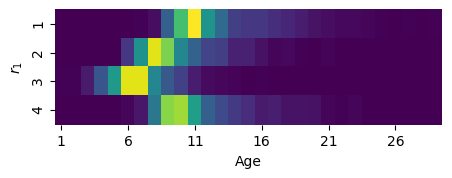

In [24]:
fig, ax = PyPlot.subplots(1,1,figsize=(5,1.5))
Seaborn.heatmap(C_EM[[3,4,2,1],:]; cmap="viridis", cbar=false, ax=ax)
ax.set_xticks([0,5,10,15,20,25] .+ 0.5)
ax.set_xticklabels([1,6,11,16,21,26])
ax.set_xlabel("Age")
ax.set_yticks([0,1,2,3] .+ 0.5)
ax.set_yticklabels([1,2,3,4])
ax.set_ylabel("\$r_1\$")
#ax.set_title("Cooccurence matrix of 'latent variable vs abalone ages'")
PyPlot.savefig("./img/abalone_DEM.pdf", bbox_inches="tight");

In [25]:
C_EM

5×29 Array{Float64,2}:
 0.0         0.0         0.0        …  0.000646412  0.0  0.0       
 0.00121655  0.00121655  0.0182482     0.0          0.0  0.0       
 0.0         0.0         0.0           0.00176056   0.0  0.00176056
 0.0         0.0         0.0           0.0          0.0  0.0       
 0.0         0.0         0.0           0.0          0.0  0.0       

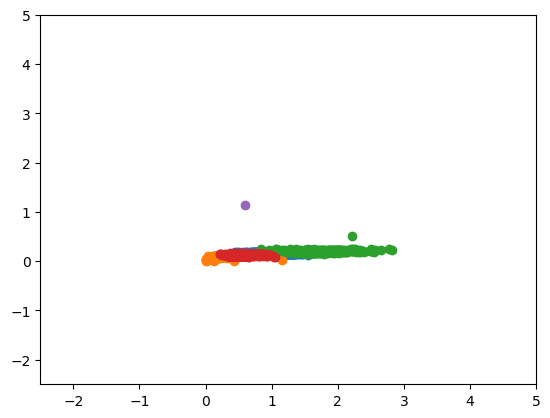

(-2.5, 5)

In [26]:
for r ∈ 1:R
    PyPlot.scatter(X₁[r_EM .== r], X₂[r_EM .== r])
end
PyPlot.xlim(-2.5,5)
PyPlot.ylim(-2.5,5)

In [27]:
C_PG = 1.0*cooccurrences([r_PG Int.(abalone_data[:rings])])
C_PG ./= sum(C_PG,dims=2)

5×29 Array{Float64,2}:
 0.0        0.0        0.0       0.00540541  …  0.0         0.0  0.0        
 0.0        0.0        0.0       0.0            0.0         0.0  0.0        
 0.0        0.0        0.0       0.0            0.0         0.0  0.0        
 0.0        0.0        0.0       0.0            0.00115473  0.0  0.000577367
 0.0018622  0.0018622  0.027933  0.102421       0.0         0.0  0.0        

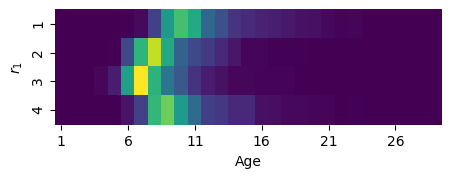

In [28]:
fig, ax = PyPlot.subplots(1,1,figsize=(5,1.5))
Seaborn.heatmap(C_PG[[4,3,1,2],:]; cmap="viridis", cbar=false, ax=ax)
ax.set_xticks([0,5,10,15,20,25] .+ 0.5)
ax.set_xticklabels([1,6,11,16,21,26])
ax.set_xlabel("Age")
ax.set_yticks([0,1,2,3] .+ 0.5)
ax.set_yticklabels([1,2,3,4])
ax.set_ylabel("\$r_1\$")
#ax.set_title("Cooccurence matrix of 'latent variable vs abalone ages'")
PyPlot.savefig("./img/abalone_PG.pdf", bbox_inches="tight");

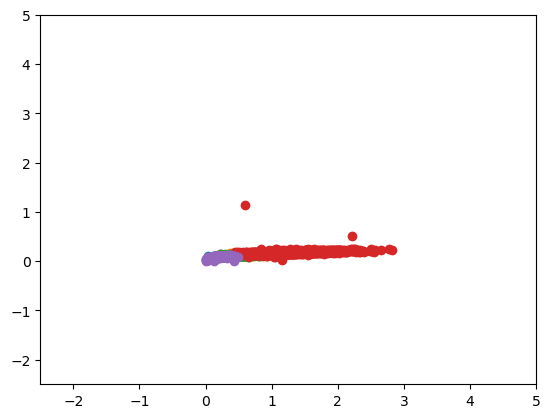

(-2.5, 5)

In [29]:
for r ∈ 1:R
    PyPlot.scatter(X₁[r_PG .== r], X₂[r_PG .== r])
end
PyPlot.xlim(-2.5,5)
PyPlot.ylim(-2.5,5)

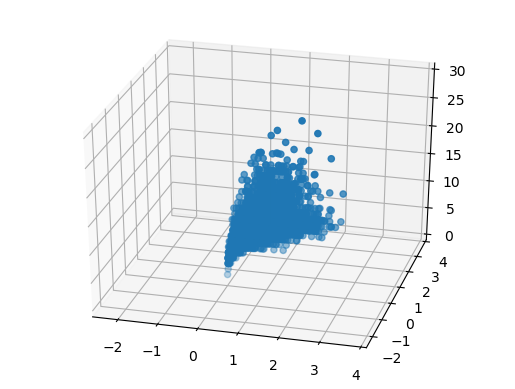

In [30]:
PyPlot.scatter3D(X₁, X₂, r_TR)
PyPlot.xlim(-2.5,4)
PyPlot.ylim(-2.5,4)
PyPlot.gca().view_init(30,-75)